## Initialize

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../src/")
import torch

from dna2vec.pinecone_store import PineconeStore

/mnt/SSD2/pholur/environments/dna2vec/lib/python3.11/site-packages/pinecone/index.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## Load Baselines

In [3]:
checkpoints = {}

checkpoints["trained"] = {}
checkpoints["trained"]["model"] = torch.load("/mnt/SSD5/pholur/checkpoints/checkpoint_smooth-rock-29.pt")

checkpoints["init"] = {}
checkpoints["init"]["model"] = torch.load("/mnt/SSD5/pholur/checkpoints/checkpoint_initalialized.pt")

print("Checkpoints loaded.")

from dna2vec.trainer import ContrastiveTrainer
from dna2vec.model import model_from_config
# The path for the tokenizer isn't relative.
for baseline in checkpoints:
    config = checkpoints[baseline]["model"]["config"]
    config.model_config.tokenizer_path = "/home/pholur/dna2vec/src/model/tokenizers/dna_tokenizer_10k.json"
    encoder, pooling, tokenizer = model_from_config(config.model_config)
    
    encoder.load_state_dict(checkpoints[baseline]["model"]["model"])
    encoder.eval()
    
    checkpoints[baseline]["encoder"] = encoder
    checkpoints[baseline]["pooling"] = pooling
    checkpoints[baseline]["tokenizer"] = tokenizer
    checkpoints[baseline]["pineconestore"] = PineconeStore(
                                                                device = torch.device("cuda:3"),
                                                                index_name = baseline,
                                                                metric = "cosine",
                                                                model_params = {
                                                                    "tokenizer": tokenizer,
                                                                    "model": encoder,
                                                                    "pooling": pooling
                                                                }
                                                            )

Checkpoints loaded.


## Validation

In [11]:
# query = "NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN" # <> 56755036" # <> 158078701
query = "CAGAGAGAATTTTTATGTTTCAATGGAAAAGTAtaacatggccaggcatggttgcacatgcctataattacagcactttgggaggccaggagttcaacatcagcctgggcaacatggtgaaaccacgtctctaccaaaaatacaaaaattagatgggcatggtggcatgtgcctgtagtcccaggtaatcaggaggctga"
# query = "tgtgcccggccaatttttctctttaaaccCATTTACATTGTTTGAATTTTCTACCTGAGCAggaatttctttaataattaaaaaaaatcttccttaaCATTTAAGGGTCAGAGTCACCTATTACTGAACATGCCATTATTCCTGTAATCTGCATACCCCTTTGTTCATTCTGTGT" # 1838202
print("Trained.")
returned = checkpoints["trained"]["pineconestore"].query([query], top_k=5)["matches"]
for sample in returned:
    returned = sample["metadata"]
    print(returned)

print("Baseline.")
returned = checkpoints["init"]["pineconestore"].query([query], top_k = 5)["matches"]
for sample in returned:
    returned = sample["metadata"]
    print(returned)

Trained.
{'position': '12000', 'text': 'CTGAAACGGAGCTATTAGTGGGGAGAGCTGATGTCCCAGTTCTTGTTTAACTTGGAAGAAAGATTTTCACCAAGAGGCAGTACAAAGATGACAGATAACTTCATTGAAAAGAAATACAGTGTAAACACCTTACTGTAGAAAAATAGGGAGGACAGGGCTGATCGTGCATGAAAACAGCCTAAGAGTCTTGTGCAGGGAAGTTACTCTAACTGTAACTTACAACAACTTAGTAGATTATACTTTTGTAAACAGAAGtgaagcatttatcttttttcttgcttGATTATTTACATAATCAAGCAAAATCtaacaaaacaataatattttaacaataatatttttaaaacaataatagtcTTACTTTGATTATGATCAAAAATGATGGTTACTACAGAGAGAATTTTTATGTTTCAATGGAAAAGTAtaacatggccaggcatggttgcacatgcctataattacagcactttgggaggccaggagttcaacatcagcctgggcaacatggtgaaaccacgtctctaccaaaaatacaaaaattagatgggcatggtggcatgtgcctgtagtcccaggtaatcaggaggctgaggagggaggatcgtttgcacccgggaagtagaggttgcagtgagctgagattgcacctttgcactccagcctaggcgacagagccagatcctgtctcaaaaaaaatttttttaaaggaaaactacagCCATTGTGGGTTATCAGATTCTagtcttgtttcttgtttctggGCTATTTTTACCTCTTTGTAAACTGCATCCTGCCATCTGATGAATTTTGTCCCACAATGATACTTGGGGAACAAGAAGCCAATTATTGTCTCTCCTACTAATGTATCTATTGTCAGTTAATTTGAAGGTCTCCAACCCTGGAACAAAGTTAGAAGAGGAAGGTTCTGCTCCCCAAAATGCATAAccaaattgtggtaca

100%|██████████| 1000/1000 [03:58<00:00,  4.19it/s]


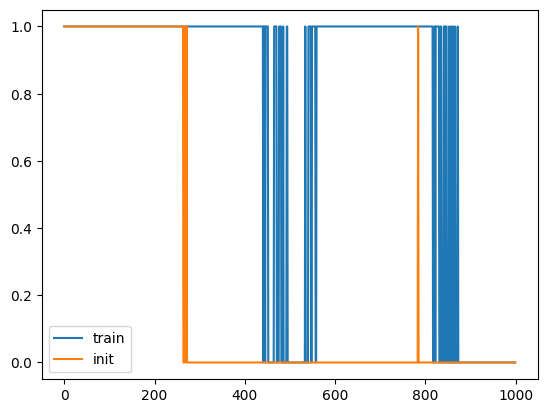

In [14]:
from tqdm import tqdm
import matplotlib.pyplot as plt

big_query = "CTGAAACGGAGCTATTAGTGGGGAGAGCTGATGTCCCAGTTCTTGTTTAACTTGGAAGAAAGATTTTCACCAAGAGGCAGTACAAAGATGACAGATAACTTCATTGAAAAGAAATACAGTGTAAACACCTTACTGTAGAAAAATAGGGAGGACAGGGCTGATCGTGCATGAAAACAGCCTAAGAGTCTTGTGCAGGGAAGTTACTCTAACTGTAACTTACAACAACTTAGTAGATTATACTTTTGTAAACAGAAGtgaagcatttatcttttttcttgcttGATTATTTACATAATCAAGCAAAATCtaacaaaacaataatattttaacaataatatttttaaaacaataatagtcTTACTTTGATTATGATCAAAAATGATGGTTACTACAGAGAGAATTTTTATGTTTCAATGGAAAAGTAtaacatggccaggcatggttgcacatgcctataattacagcactttgggaggccaggagttcaacatcagcctgggcaacatggtgaaaccacgtctctaccaaaaatacaaaaattagatgggcatggtggcatgtgcctgtagtcccaggtaatcaggaggctgaggagggaggatcgtttgcacccgggaagtagaggttgcagtgagctgagattgcacctttgcactccagcctaggcgacagagccagatcctgtctcaaaaaaaatttttttaaaggaaaactacagCCATTGTGGGTTATCAGATTCTagtcttgtttcttgtttctggGCTATTTTTACCTCTTTGTAAACTGCATCCTGCCATCTGATGAATTTTGTCCCACAATGATACTTGGGGAACAAGAAGCCAATTATTGTCTCTCCTACTAATGTATCTATTGTCAGTTAATTTGAAGGTCTCCAACCCTGGAACAAAGTTAGAAGAGGAAGGTTCTGCTCCCCAAAATGCATAAccaaattgtggtacattcatGTAATGGAACACTATTTAGCCATAGAAACGAACAA"
index = '12000'
import numpy as np
query = big_query
train_flag = []
init_flag = []
for i in tqdm(range(len(big_query))):
    
    returned = checkpoints["trained"]["pineconestore"].query([query], top_k=5)["matches"]
    trained_positions = [sample["metadata"]["position"] for sample in returned]
    
    returned = checkpoints["init"]["pineconestore"].query([query], top_k=5)["matches"]
    init_positions = [sample["metadata"]["position"] for sample in returned]
    if index in trained_positions:
        train_flag.append(1)
    else:
        train_flag.append(0)
    
    if index in init_positions:
        init_flag.append(1)
    else:
        init_flag.append(0)
        
    if np.random.rand() > 0.5:
        query = query[1:]
    else:
        query = query[:-1]

plt.plot(range(len(big_query)), train_flag, label="train")
plt.plot(range(len(big_query)), init_flag, label="init")
plt.legend()
plt.show()

100%|██████████| 1000/1000 [04:34<00:00,  3.64it/s]


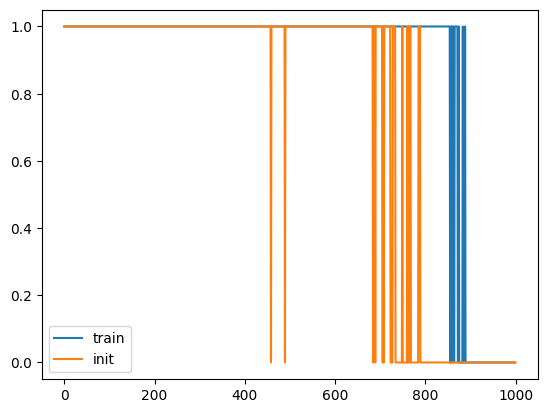

In [15]:
big_query = "CTGAAACGGAGCTATTAGTGGGGAGAGCTGATGTCCCAGTTCTTGTTTAACTTGGAAGAAAGATTTTCACCAAGAGGCAGTACAAAGATGACAGATAACTTCATTGAAAAGAAATACAGTGTAAACACCTTACTGTAGAAAAATAGGGAGGACAGGGCTGATCGTGCATGAAAACAGCCTAAGAGTCTTGTGCAGGGAAGTTACTCTAACTGTAACTTACAACAACTTAGTAGATTATACTTTTGTAAACAGAAGtgaagcatttatcttttttcttgcttGATTATTTACATAATCAAGCAAAATCtaacaaaacaataatattttaacaataatatttttaaaacaataatagtcTTACTTTGATTATGATCAAAAATGATGGTTACTACAGAGAGAATTTTTATGTTTCAATGGAAAAGTAtaacatggccaggcatggttgcacatgcctataattacagcactttgggaggccaggagttcaacatcagcctgggcaacatggtgaaaccacgtctctaccaaaaatacaaaaattagatgggcatggtggcatgtgcctgtagtcccaggtaatcaggaggctgaggagggaggatcgtttgcacccgggaagtagaggttgcagtgagctgagattgcacctttgcactccagcctaggcgacagagccagatcctgtctcaaaaaaaatttttttaaaggaaaactacagCCATTGTGGGTTATCAGATTCTagtcttgtttcttgtttctggGCTATTTTTACCTCTTTGTAAACTGCATCCTGCCATCTGATGAATTTTGTCCCACAATGATACTTGGGGAACAAGAAGCCAATTATTGTCTCTCCTACTAATGTATCTATTGTCAGTTAATTTGAAGGTCTCCAACCCTGGAACAAAGTTAGAAGAGGAAGGTTCTGCTCCCCAAAATGCATAAccaaattgtggtacattcatGTAATGGAACACTATTTAGCCATAGAAACGAACAA"
index = '12000'
from tqdm import tqdm
import numpy as np
query = big_query
train_flag = []
init_flag = []
for i in tqdm(range(len(big_query))):
    
    returned = checkpoints["trained"]["pineconestore"].query([query], top_k=50)["matches"]
    trained_positions = [sample["metadata"]["position"] for sample in returned]
    
    returned = checkpoints["init"]["pineconestore"].query([query], top_k=50)["matches"]
    init_positions = [sample["metadata"]["position"] for sample in returned]
    if index in trained_positions:
        train_flag.append(1)
    else:
        train_flag.append(0)
    
    if index in init_positions:
        init_flag.append(1)
    else:
        init_flag.append(0)
        
    if np.random.rand() > 0.5:
        query = query[1:]
    else:
        query = query[:-1]
import matplotlib.pyplot as plt
plt.plot(range(len(big_query)), train_flag, label="train")
plt.plot(range(len(big_query)), init_flag, label="init")
plt.legend()
plt.show()

In [8]:
import editdistance
with open("/home/pholur/dna2vec/tests/data/subsequences_sample_test.txt", "r") as f:
    lines = f.readlines()

print("Trained")
distance = 0
total_edit = 0

from tqdm import tqdm
for line in tqdm(lines):
    text = line.split(" <> ")[0]
    index_scraped = int(line.split(" <> ")[1])
    returned_raw = checkpoints["trained"]["pineconestore"].query([text], top_k=1)
    returned = int(returned_raw["matches"][0]["metadata"]["position"])
    distance += abs(index_scraped - returned)
    total_edit += editdistance.eval(text, returned_raw["matches"][0]["metadata"]["text"])

    
print("Average distance: ", distance / len(lines))
print("Edit distance: ", total_edit)

print("Init")
total_edit = 0
for line in tqdm(lines):
    text = line.split(" <> ")[0]
    index_scraped = int(line.split(" <> ")[1])
    returned_raw = checkpoints["init"]["pineconestore"].query([text], top_k=1)
    returned = int(returned_raw["matches"][0]["metadata"]["position"])
    distance += abs(index_scraped - returned)
    total_edit += editdistance.eval(text, returned_raw["matches"][0]["metadata"]["text"])
    
print("Average distance: ", distance / len(lines))
print("Edit distance: ", total_edit)

Trained


100%|██████████| 1000/1000 [00:50<00:00, 19.62it/s]


Average distance:  94969201.418
Edit distance:  887167
Init


100%|██████████| 1000/1000 [03:10<00:00,  5.24it/s]

Average distance:  195319923.792
Edit distance:  844198


In [1]:
import os
with open(os.path.join("/home/pholur/dna2vec/tests/data/NC_000002.12.txt"), "r") as f:
    sequence = f.read()
    print(len(sequence)/2)

# 0.25M and clustering, increase the number of test samples?
# what will impress you? what is the least amount to do that we need to publish
# letters...
# sampling / sampling with mutations
# what is the minimum bar for creating excitement

121096764.5


In [36]:
print("Trained")
from tqdm import tqdm
import numpy as np
mapper_train = {}
mapper_init = {}
distance = 0

for k in [1,2,5,10,20]:
    distance = 0
    for line in tqdm(lines):
        text = line.split(" <> ")[0]
        index_scraped = int(line.split(" <> ")[1])
        returned_raw = checkpoints["trained"]["pineconestore"].query([text], top_k=k)
        offsets =  [abs(index_scraped - int(returned_raw["matches"][i]["metadata"]["position"])) for i in range(k)]
        returned = int(returned_raw["matches"][np.argmin(offsets)]["metadata"]["position"])
        distance += abs(index_scraped - returned)
        
    mapper_train[k] = distance/len(lines)

    print("Init")
    distance = 0
    for line in tqdm(lines):
        text = line.split(" <> ")[0]
        index_scraped = int(line.split(" <> ")[1])
        returned_raw = checkpoints["init"]["pineconestore"].query([text], top_k=k)
        offsets =  [abs(index_scraped - int(returned_raw["matches"][i]["metadata"]["position"])) for i in range(k)]
        returned = int(returned_raw["matches"][np.argmin(offsets)]["metadata"]["position"])
        distance += abs(index_scraped - returned)
    
    mapper_init[k] = distance/len(lines)

Trained


100%|██████████| 1000/1000 [00:50<00:00, 19.65it/s]


Init


100%|██████████| 1000/1000 [00:51<00:00, 19.51it/s]


Init


100%|██████████| 1000/1000 [00:52<00:00, 18.95it/s]


Init


100%|██████████| 1000/1000 [00:53<00:00, 18.82it/s]


Init


100%|██████████| 1000/1000 [00:56<00:00, 17.55it/s]


Init


100%|██████████| 1000/1000 [03:18<00:00,  5.03it/s]


## Edit Distance

In [23]:
import editdistance
query = "aagaagacctagtatttgacagcacaacagggtgaatATAATCATAATgactgcacattttaaaataatgaaaagagtagaattggattgtaacacaaaggagaaatgtttgaggggatggataccccgtTTACCCTGATGTGGTTATTGCATGTTGCATGT" # <> 158078701

# query = "tgtgcccggccaatttttctctttaaaccCATTTACATTGTTTGAATTTTCTACCTGAGCAggaatttctttaataattaaaaaaaatcttccttaaCATTTAAGGGTCAGAGTCACCTATTACTGAACATGCCATTATTCCTGTAATCTGCATACCCCTTTGTTCATTCTGTGT" # 1838202

print("Trained.")
returned = checkpoints["trained"]["pineconestore"].query([query])["matches"]
for sample in returned:
    returned_marg = sample["metadata"]
    print(editdistance.eval(query, returned_marg["text"]))
    print(returned_marg)

print("Baseline.")
returned = checkpoints["init"]["pineconestore"].query([query])["matches"]
for sample in returned:
    returned_marg = sample["metadata"]
    print(editdistance.eval(query, returned_marg["text"]))
    print(returned_marg)

Trained.
160
{'position': '121611960', 'text': 'GGCATTGGAGGAGTTACAGGATAAAGTggaactggaggaggaggagaaggagttacaggaggaagaggaactggAAGAGGAGGAGttacaggaggaagaggaactggaggaggaggagttggaggagttacaggagaaagaggaactggaggaggaggaggagttacaggaggaagaggaactggaggaggaggagttggaggagtttcaggaggaagaggatgaggaggaggagttaCAGGCAgaa'}
133
{'position': '121610571', 'text': 'ggaagaggaactggagaaggaggaggaggagttgcaggaggaagaggaactggaggaggaggaggagttacaggaggaagaggaactggaggaggaggagttggaggagttacaggagaaagaggaactggagaaggaggaggaggagttacaggagaaagaggaactggaggaggaagagttacaggaggaagaggaactggaggaggaggaaga'}
136
{'position': '172923968', 'text': 'taaaaaaaatctttgtatgtTGAGTCAAGCTCTAGAAAATCAGGCTCATAAAGATTCTAAAGGAACAAACTGATCTTGCCACCATTTTGGACATGGATGTCCCAAATTATCCATCCTACAACAAATAATACACAAATCATTTGCCaaataaagaaga'}
143
{'position': '133054186', 'text': 'GTTTACCCAGAAACTCAATTATTCCTTCCACAAACATTGATGGAGATCACACCTTGTTTAATAAAGTATTAGCAATATGATGGTATGTTACCTCCCCACCCCAGTAGGGAGAGAACCTGTACAGAAATAACCATAGAACAAAGCCAAATATG'}
141
{'position': '104221503', 'text': 'aaaagatTTGTT

/mnt/SSD2/pholur/environments/dna2vec/lib/python3.11/site-packages/torch/nn/modules/transformer.py:562: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._transformer_encoder_layer_fwd(


192
{'position': '134865024', 'text': 'gcaAAATCTTTAATAATGACTTAAATAGATGTTTGTGGACTCACCAGGCACTGTGACTACTGATCATTTACTCATTTAGTATTTACTGAGGTCTAACTACAGGCAAAAAATTTTCCATGTTTGTATCTATGGCGACTGCCCACCAGTCAGGAGATTGCCTGTTAAATTGCCTTCTAATGACTTGAAAGATTTAATGTTCCTCAATATACTGAACTCCCTGAAGCTTACTGGCTG'}
147
{'position': '85754925', 'text': 'TCAGCGCAGCCTTCGAGGCGCTCAGGAAGCAGGTACCCGCTCGCCGCCGCACGCCCTCACTGCGCCGGGGGACGACTGCGGGAATGGGTGGGCGAGTGGCCGGGGCGGGATAGAGGTGTGTTTAAGGGGCAAGCTGCCCCGCCCGGTCCGAC'}
190
{'position': '242047020', 'text': 'CGATGGGCTCCCCGCAGCGGAGACAGACGCCGGGGCGGCGATGGGCTCCCCGCAGCGGAGACAGACGCCGGGGCGGCGATGGGCTCCCCGCAGCGGAGACAGACGCCGGGGCGGCGATGGGCTCCCCGCAGCGGAGAGAGACGCCGGGGCGGCGATGGGCTCCCCGCAGCGGAGAGAGACGCCGGGGCCGCGATGGGCTCCCCGCAGCGGAGAGAGA'}
142
{'position': '174813138', 'text': 'TACTTTTTTCCCTCATATTATATctgagaaaaccaaacacagaagTAATAAGTAATTTACCCAAGGCCATGCATTTAGTACACAGTGGAACAGAACTCAAGCCTATGGATGATTCTAgagtccacattttaaaaatgtttactgtttAATTACAAAGGATATAGCTGAAGAGACGTATAGGATGAGGTATGGGGAAAGGGGT'}
176
{'position': '219442147'

In [ ]:
# Compute the edit distances
# 10-most similar